#### 1. 패키지 로딩하기

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import Image
from catboost import CatBoostRegressor
from statsmodels.tsa.arima_model import ARIMA

#### 2. 데이터 불러오기

* 2_1. 데이터 경로 지정하기

In [3]:
train_path      = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/sales_train.csv"
test_path       = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/test.csv"
submission_path = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/sample_submission.csv"

* 2_2. 데이터 읽어오기

In [4]:
train_data      = pd.read_csv(filepath_or_buffer = train_path)
test_data       = pd.read_csv(filepath_or_buffer = test_path)
submission_data = pd.read_csv(filepath_or_buffer = submission_path)

#### 3. 데이터 살펴보기

* 3_1. 훈련 데이터

In [5]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


* 3_2. 테스트 데이터

In [6]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


* 3_3. 제출 양식

In [7]:
submission_data.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


* 3_4. 각 파일의 shape / info

In [8]:
print(train_data.shape)
print(test_data.shape)
print(submission_data.shape)

(2935849, 6)
(214200, 3)
(214200, 2)


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


#### 4. 데이터 전처리

* 4_1. 결측치 유무 확인하기

In [11]:
for c in train_data.columns:
    print("{} : {}".format(c, len(train_data.loc[pd.isnull(train_data[c]), c].values)))

date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [11]:
for c in test_data.columns:
    print("{} : {}".format(c, len(test_data.loc[pd.isnull(test_data[c]), c].values)))

ID : 0
shop_id : 0
item_id : 0


<AxesSubplot:>

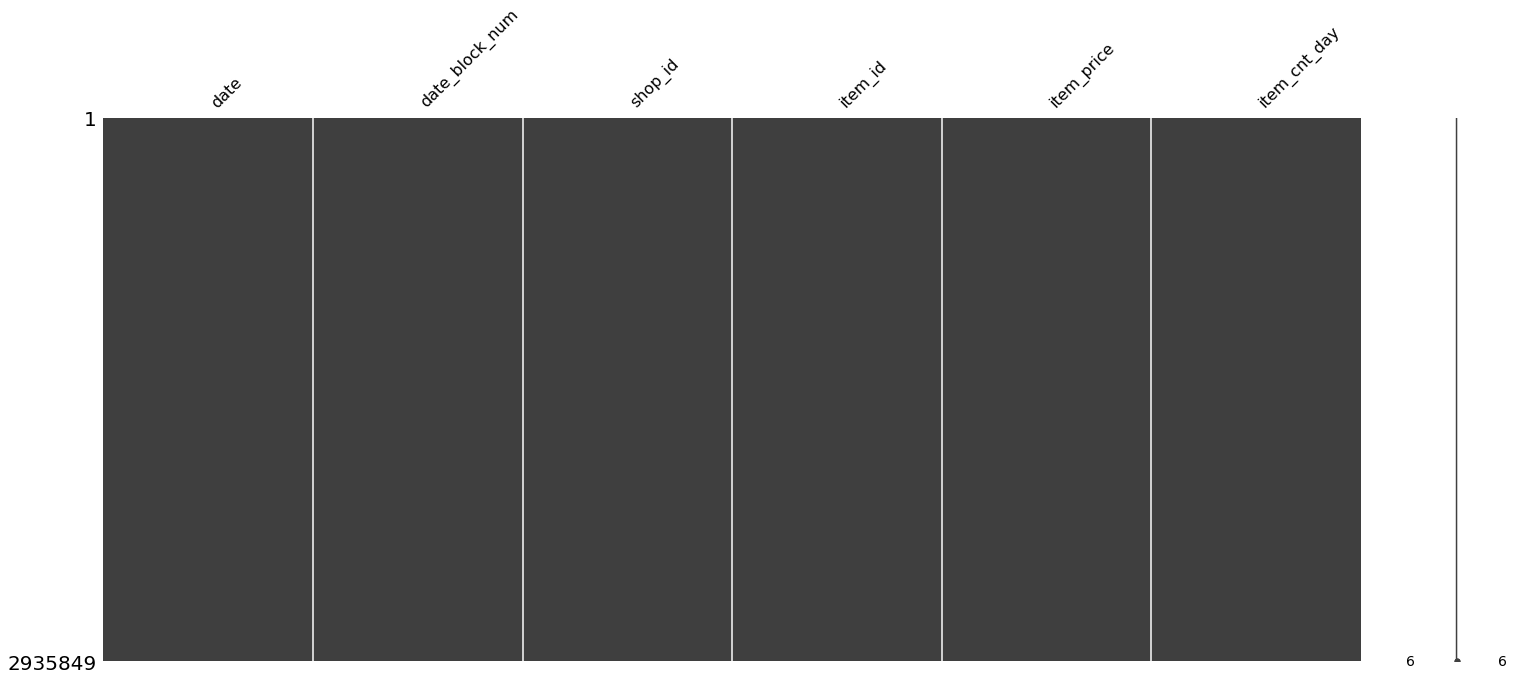

In [12]:
msno.matrix(train_data)

<AxesSubplot:>

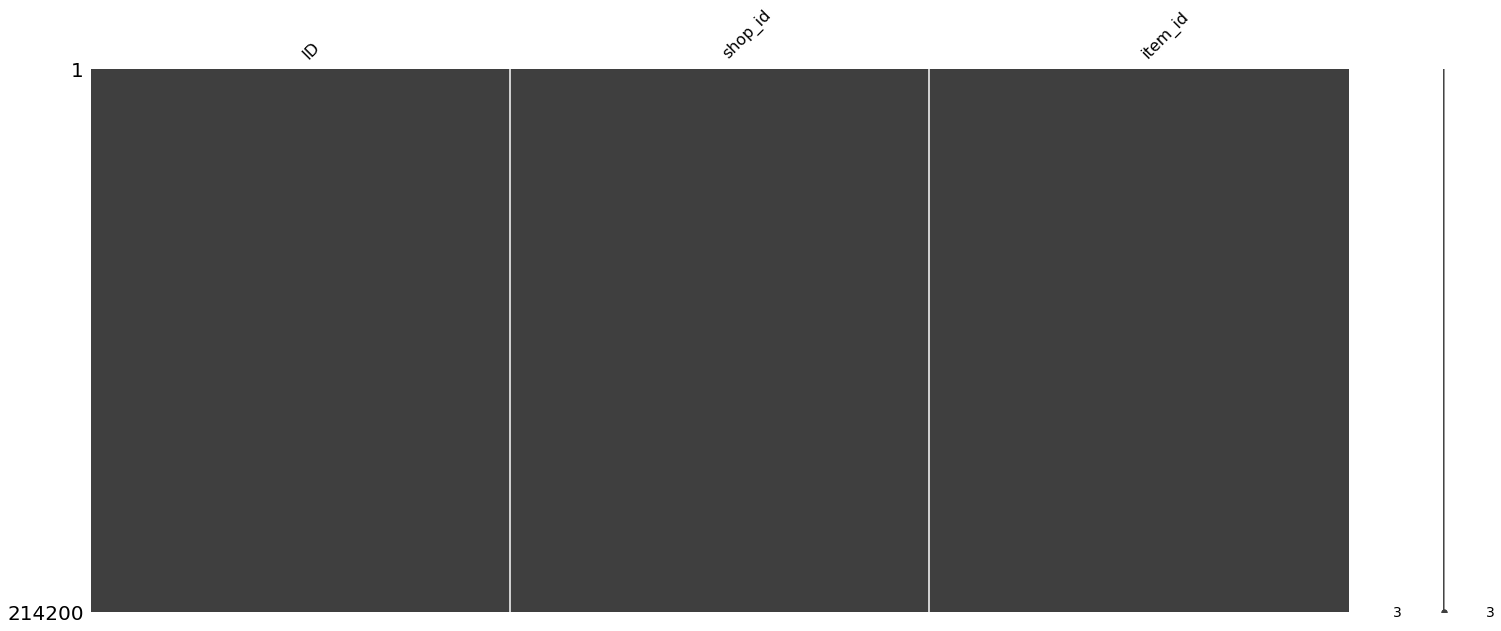

In [13]:
msno.matrix(test_data)

* 4_2. date 칼럼 수정하기

In [12]:
train_data["date"] = train_data["date"].apply(lambda x : datetime.datetime.strptime(x, "%d.%m.%Y"))

In [15]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


* 4_3. 칼럼 분포 확인하기

In [14]:
# "x"에 따른 판매량 그래프 그리는 함수
def get_plot(x : list):
    temp              = train_data.groupby(x)["item_cnt_day"].sum()
    temp.plot(figsize = (10, 10))

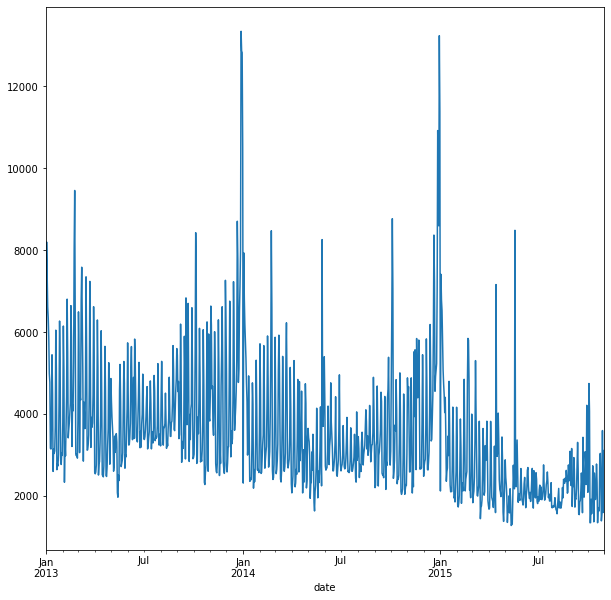

In [17]:
# 일자별 판매량
get_plot("date")

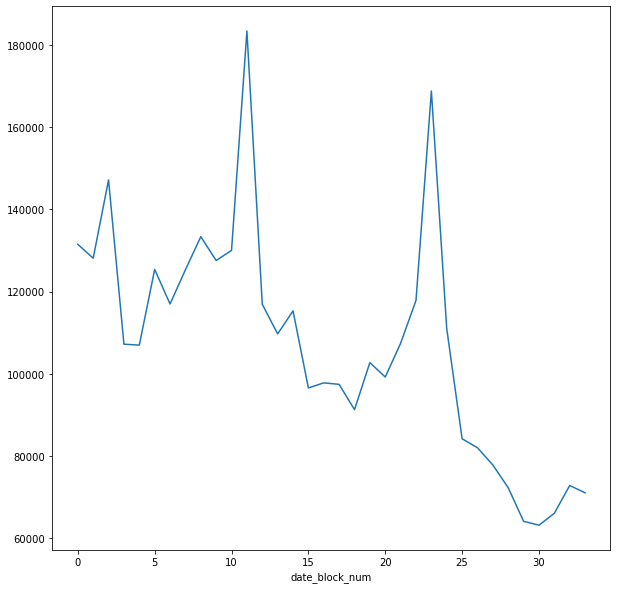

In [15]:
# 월별에 따른 판매량
get_plot("date_block_num")

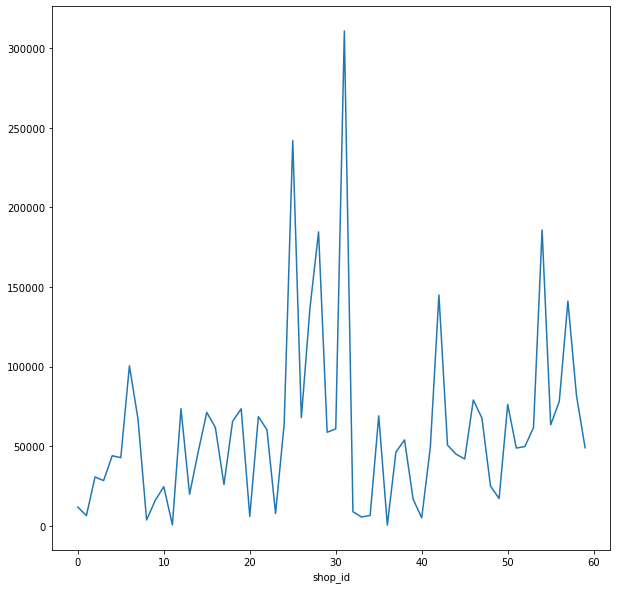

In [19]:
# 가계에 따른 판매량
get_plot("shop_id")

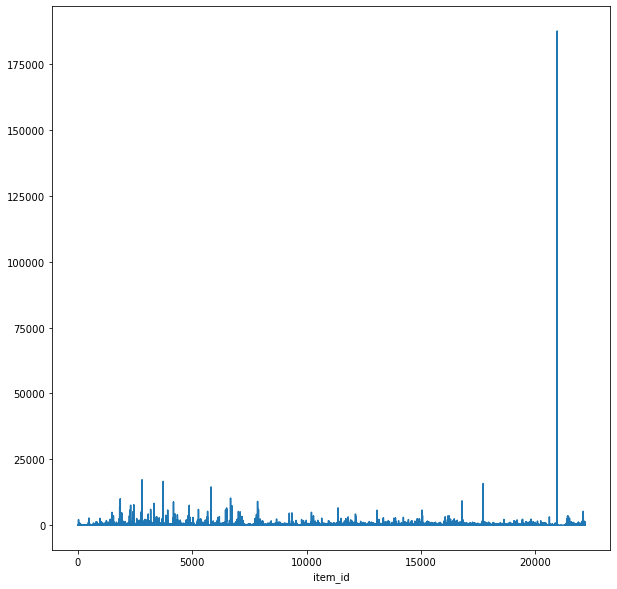

In [20]:
# 아이템에 따른 판매량
get_plot("item_id")

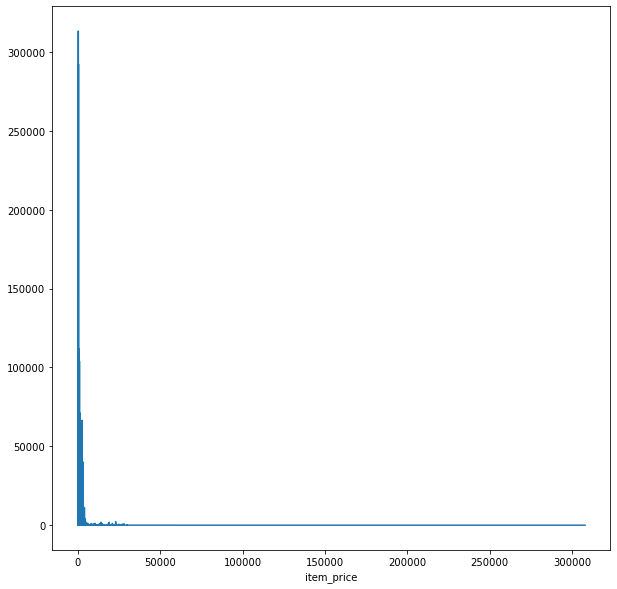

In [21]:
# 가격별 판매량
get_plot("item_price")

* 4_4. 훈련 데이터 변수별 이상치 확인하기

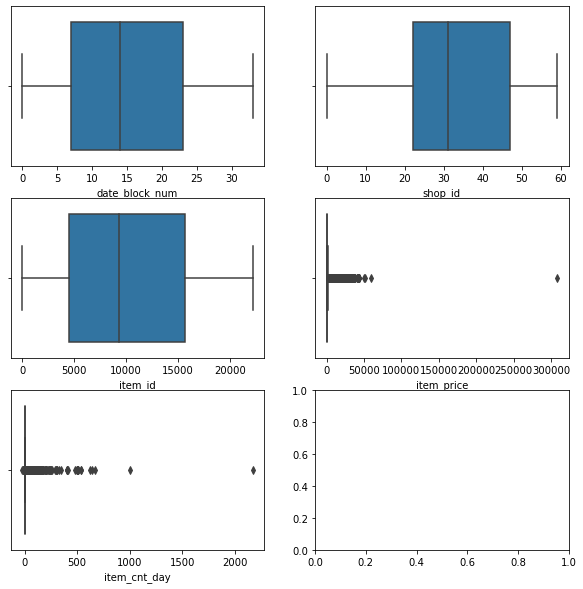

In [22]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count   = 1
columns = train_data.columns
try:
    for row in range(3):
        for col in range(2):
            sns.boxplot(x = columns[count], data = train_data, ax = ax[row][col])
            count += 1
except IndexError:
    pass

* 4_5. 훈련 데이터별 분포 확인하기

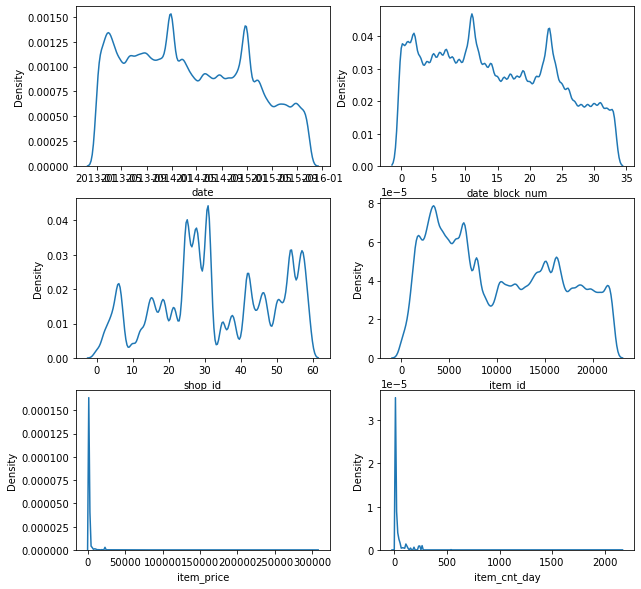

In [23]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count   = 0
columns = train_data.columns

for row in range(3):
    for col in range(2):
        sns.kdeplot(train_data[columns[count]], ax = ax[row][col])
        count += 1

* 4_6. 데이터 이상치 탐색 및 제거

In [16]:
train_data[train_data["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [17]:
train_data[train_data["item_price"] > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [18]:
train_data[train_data["item_cnt_day"] > 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [19]:
train_data[train_data["item_cnt_day"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,2013-01-05,0,25,2552,899.0,-1.0
148,2013-01-23,0,25,2321,999.0,-1.0
175,2013-01-07,0,25,2199,1449.0,-1.0
807,2013-01-02,0,25,2330,599.0,-1.0
1041,2013-01-13,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1.0
2934462,2015-10-18,33,25,4896,6398.0,-1.0
2935263,2015-10-05,33,25,10039,249.0,-1.0
2935643,2015-10-16,33,25,7893,2990.0,-1.0


In [20]:
index      = train_data[train_data["item_price"] < 0].index
train_data = train_data.drop(index)

In [21]:
index      = train_data[train_data["item_price"] > 300000].index
train_data = train_data.drop(index)

In [22]:
index      = train_data[train_data["item_cnt_day"] > 2000].index
train_data = train_data.drop(index)

In [23]:
index      = train_data[train_data["item_cnt_day"] < 0].index
train_data = train_data.drop(index)

In [24]:
train_data[train_data["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [25]:
train_data[train_data["item_price"] > 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [26]:
train_data[train_data["item_cnt_day"] > 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [27]:
train_data[train_data["item_cnt_day"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [28]:
train_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


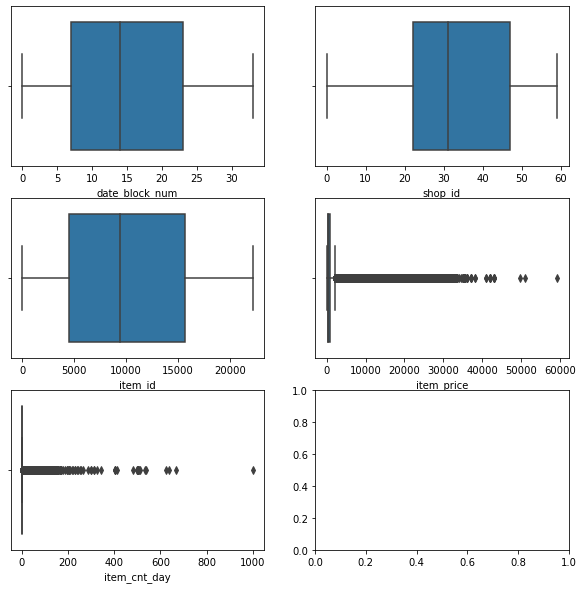

In [37]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count = 1
columns = train_data.columns
try:
    for row in range(3):
        for col in range(2):
            sns.boxplot(x = columns[count], data = train_data, ax = ax[row][col])
            count += 1
except IndexError:
    pass

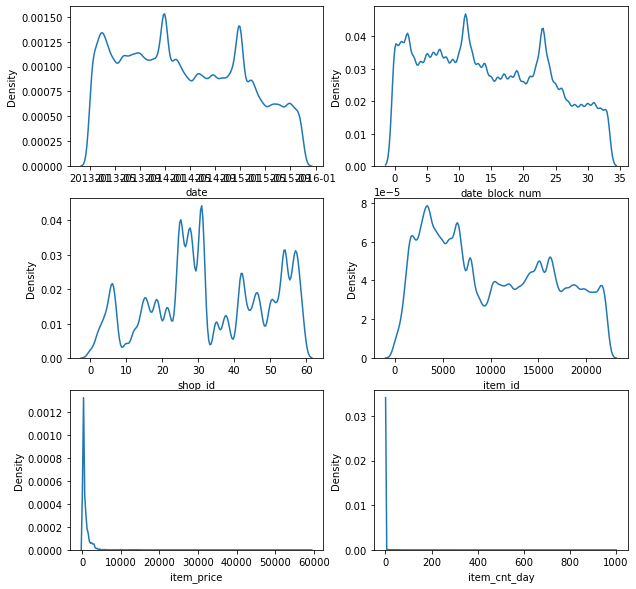

In [53]:
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

count   = 0
columns = train_data.columns

for row in range(3):
    for col in range(2):
        sns.kdeplot(train_data[columns[count]], ax = ax[row][col])
        count += 1

#### 5. feature, label 분리하기

In [30]:
day_train_data = train_data.groupby(["date", "date_block_num", "shop_id", "item_id"], as_index = False).agg({"item_cnt_day" : "sum"})
day_train_data.head(10)

,date,date_block_num,shop_id,item_id,item_cnt_day
0,2013-01-01,0,2,991,1.0
1,2013-01-01,0,2,1472,1.0
2,2013-01-01,0,2,1905,1.0
3,2013-01-01,0,2,2920,2.0
4,2013-01-01,0,2,3320,1.0
5,2013-01-01,0,2,4464,1.0
6,2013-01-01,0,2,4724,1.0
7,2013-01-01,0,2,5649,1.0
8,2013-01-01,0,2,6911,1.0
9,2013-01-01,0,2,6916,1.0


In [31]:
month_train_data = train_data.groupby(["date_block_num", "shop_id", "item_id"], as_index = False).agg({"item_cnt_day" : "sum"})
month_train_data.head(10)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
5,0,0,61,1.0
6,0,0,75,1.0
7,0,0,88,1.0
8,0,0,95,1.0
9,0,0,96,1.0


In [32]:
train = month_train_data.iloc[:, :-1]
train

,date_block_num,shop_id,item_id
0,0,0,32
1,0,0,33
2,0,0,35
3,0,0,43
4,0,0,51
...,...,...,...
1608220,33,59,22087
1608221,33,59,22088
1608222,33,59,22091
1608223,33,59,22100


In [33]:
y = month_train_data.iloc[:, -1]
y

0          6.0
1          3.0
2          1.0
3          1.0
4          2.0
          ... 
1608220    6.0
1608221    2.0
1608222    1.0
1608223    1.0
1608224    1.0
Name: item_cnt_day, Length: 1608225, dtype: float64

In [41]:
print(train.shape)
print(y.shape)

(1608225, 3)
(1608225,)


#### 6. 훈련 데이터와 테스트 데이터 변수 정리하기

In [34]:
del test_data["ID"]
test_data

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [35]:
del train["date_block_num"]
train

,shop_id,item_id
0,0,32
1,0,33
2,0,35
3,0,43
4,0,51
...,...,...
1608220,59,22087
1608221,59,22088
1608222,59,22091
1608223,59,22100


In [36]:
del month_train_data["date_block_num"]
month_train_data

,shop_id,item_id,item_cnt_day
0,0,32,6.0
1,0,33,3.0
2,0,35,1.0
3,0,43,1.0
4,0,51,2.0
...,...,...,...
1608220,59,22087,6.0
1608221,59,22088,2.0
1608222,59,22091,1.0
1608223,59,22100,1.0


In [37]:
y

0          6.0
1          3.0
2          1.0
3          1.0
4          2.0
          ... 
1608220    6.0
1608221    2.0
1608222    1.0
1608223    1.0
1608224    1.0
Name: item_cnt_day, Length: 1608225, dtype: float64

#### 7. feature, y 분포 확인하기

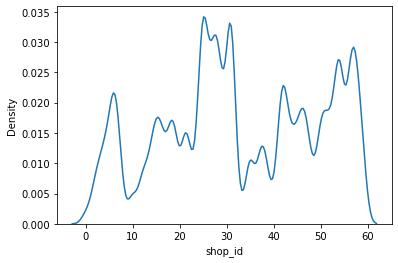

In [45]:
sns.kdeplot(train["shop_id"])
plt.show()

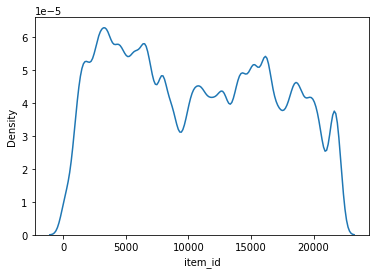

In [46]:
sns.kdeplot(train["item_id"])
plt.show()

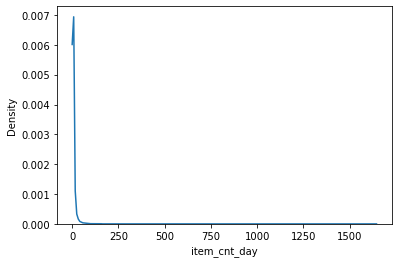

In [47]:
sns.kdeplot(y)
plt.show()

In [38]:
y = np.log1p(y)

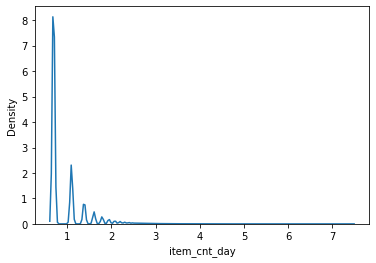

In [39]:
sns.kdeplot(y)
plt.show()

In [51]:
month_train_data["item_cnt_day"] = np.log1p(month_train_data["item_cnt_day"])
month_train_data

,shop_id,item_id,item_cnt_day
0,0,32,0.732569
1,0,33,0.625800
2,0,35,0.423036
3,0,43,0.423036
4,0,51,0.554618
...,...,...,...
1608220,59,22087,0.732569
1608221,59,22088,0.554618
1608222,59,22091,0.423036
1608223,59,22100,0.423036


In [50]:
y_2 = month_train_data["item_cnt_day"]
y_2

0          1.080418
1          0.869742
2          0.526589
3          0.526589
4          0.741276
             ...   
1608220    1.080418
1608221    0.741276
1608222    0.526589
1608223    0.526589
1608224    0.526589
Name: item_cnt_day, Length: 1608225, dtype: float64

#### 8. 모델을 구성하고 학습 및 예측하기

In [53]:
cbr = CatBoostRegressor()
cbr.fit(train, y_2)

Learning rate set to 0.145255
0:	learn: 0.1117307	total: 116ms	remaining: 1m 56s
1:	learn: 0.1113348	total: 186ms	remaining: 1m 32s
2:	learn: 0.1110342	total: 251ms	remaining: 1m 23s
3:	learn: 0.1108233	total: 309ms	remaining: 1m 16s
4:	learn: 0.1106449	total: 372ms	remaining: 1m 13s
5:	learn: 0.1104720	total: 447ms	remaining: 1m 14s
6:	learn: 0.1103139	total: 514ms	remaining: 1m 12s
7:	learn: 0.1102011	total: 579ms	remaining: 1m 11s
8:	learn: 0.1099829	total: 650ms	remaining: 1m 11s
9:	learn: 0.1098974	total: 723ms	remaining: 1m 11s
10:	learn: 0.1097360	total: 794ms	remaining: 1m 11s
11:	learn: 0.1096483	total: 862ms	remaining: 1m 10s
12:	learn: 0.1095510	total: 934ms	remaining: 1m 10s
13:	learn: 0.1094760	total: 993ms	remaining: 1m 9s
14:	learn: 0.1094056	total: 1.06s	remaining: 1m 9s
15:	learn: 0.1093353	total: 1.12s	remaining: 1m 9s
16:	learn: 0.1092854	total: 1.19s	remaining: 1m 8s
17:	learn: 0.1092206	total: 1.26s	remaining: 1m 8s
18:	learn: 0.1091728	total: 1.32s	remaining: 1m 8

161:	learn: 0.1059187	total: 10.3s	remaining: 53.5s
162:	learn: 0.1059138	total: 10.4s	remaining: 53.3s
163:	learn: 0.1059055	total: 10.5s	remaining: 53.3s
164:	learn: 0.1059028	total: 10.5s	remaining: 53.1s
165:	learn: 0.1058895	total: 10.6s	remaining: 53.1s
166:	learn: 0.1058838	total: 10.6s	remaining: 53s
167:	learn: 0.1058604	total: 10.7s	remaining: 53s
168:	learn: 0.1058470	total: 10.8s	remaining: 52.9s
169:	learn: 0.1058358	total: 10.8s	remaining: 52.9s
170:	learn: 0.1058176	total: 10.9s	remaining: 52.8s
171:	learn: 0.1058133	total: 10.9s	remaining: 52.7s
172:	learn: 0.1058100	total: 11s	remaining: 52.6s
173:	learn: 0.1057948	total: 11.1s	remaining: 52.6s
174:	learn: 0.1057900	total: 11.1s	remaining: 52.4s
175:	learn: 0.1057818	total: 11.2s	remaining: 52.4s
176:	learn: 0.1057763	total: 11.2s	remaining: 52.3s
177:	learn: 0.1057653	total: 11.3s	remaining: 52.2s
178:	learn: 0.1057618	total: 11.4s	remaining: 52.1s
179:	learn: 0.1057560	total: 11.4s	remaining: 52s
180:	learn: 0.105740

321:	learn: 0.1050358	total: 20.5s	remaining: 43.1s
322:	learn: 0.1050315	total: 20.5s	remaining: 43s
323:	learn: 0.1050277	total: 20.6s	remaining: 43s
324:	learn: 0.1050261	total: 20.7s	remaining: 42.9s
325:	learn: 0.1050238	total: 20.7s	remaining: 42.8s
326:	learn: 0.1050221	total: 20.8s	remaining: 42.8s
327:	learn: 0.1050206	total: 20.8s	remaining: 42.7s
328:	learn: 0.1050181	total: 20.9s	remaining: 42.6s
329:	learn: 0.1050135	total: 21s	remaining: 42.6s
330:	learn: 0.1050074	total: 21s	remaining: 42.5s
331:	learn: 0.1050054	total: 21.1s	remaining: 42.4s
332:	learn: 0.1050017	total: 21.2s	remaining: 42.4s
333:	learn: 0.1049927	total: 21.2s	remaining: 42.3s
334:	learn: 0.1049898	total: 21.3s	remaining: 42.2s
335:	learn: 0.1049875	total: 21.4s	remaining: 42.2s
336:	learn: 0.1049866	total: 21.4s	remaining: 42.1s
337:	learn: 0.1049844	total: 21.5s	remaining: 42s
338:	learn: 0.1049776	total: 21.5s	remaining: 42s
339:	learn: 0.1049737	total: 21.6s	remaining: 41.9s
340:	learn: 0.1049676	to

481:	learn: 0.1046574	total: 30.6s	remaining: 32.9s
482:	learn: 0.1046557	total: 30.7s	remaining: 32.8s
483:	learn: 0.1046545	total: 30.7s	remaining: 32.7s
484:	learn: 0.1046531	total: 30.8s	remaining: 32.7s
485:	learn: 0.1046522	total: 30.9s	remaining: 32.6s
486:	learn: 0.1046506	total: 30.9s	remaining: 32.6s
487:	learn: 0.1046485	total: 31s	remaining: 32.5s
488:	learn: 0.1046459	total: 31s	remaining: 32.4s
489:	learn: 0.1046450	total: 31.1s	remaining: 32.4s
490:	learn: 0.1046435	total: 31.2s	remaining: 32.3s
491:	learn: 0.1046427	total: 31.2s	remaining: 32.2s
492:	learn: 0.1046413	total: 31.3s	remaining: 32.2s
493:	learn: 0.1046401	total: 31.4s	remaining: 32.1s
494:	learn: 0.1046388	total: 31.4s	remaining: 32.1s
495:	learn: 0.1046379	total: 31.5s	remaining: 32s
496:	learn: 0.1046359	total: 31.6s	remaining: 31.9s
497:	learn: 0.1046348	total: 31.6s	remaining: 31.9s
498:	learn: 0.1046332	total: 31.7s	remaining: 31.8s
499:	learn: 0.1046309	total: 31.8s	remaining: 31.8s
500:	learn: 0.1046

643:	learn: 0.1044610	total: 40.9s	remaining: 22.6s
644:	learn: 0.1044600	total: 41s	remaining: 22.6s
645:	learn: 0.1044595	total: 41s	remaining: 22.5s
646:	learn: 0.1044575	total: 41.1s	remaining: 22.4s
647:	learn: 0.1044566	total: 41.2s	remaining: 22.4s
648:	learn: 0.1044539	total: 41.2s	remaining: 22.3s
649:	learn: 0.1044532	total: 41.3s	remaining: 22.2s
650:	learn: 0.1044518	total: 41.3s	remaining: 22.2s
651:	learn: 0.1044513	total: 41.4s	remaining: 22.1s
652:	learn: 0.1044508	total: 41.5s	remaining: 22.1s
653:	learn: 0.1044494	total: 41.6s	remaining: 22s
654:	learn: 0.1044485	total: 41.7s	remaining: 21.9s
655:	learn: 0.1044476	total: 41.7s	remaining: 21.9s
656:	learn: 0.1044468	total: 41.8s	remaining: 21.8s
657:	learn: 0.1044455	total: 41.9s	remaining: 21.8s
658:	learn: 0.1044451	total: 41.9s	remaining: 21.7s
659:	learn: 0.1044445	total: 42s	remaining: 21.6s
660:	learn: 0.1044436	total: 42s	remaining: 21.6s
661:	learn: 0.1044431	total: 42.1s	remaining: 21.5s
662:	learn: 0.1044426	

805:	learn: 0.1043274	total: 52s	remaining: 12.5s
806:	learn: 0.1043265	total: 52s	remaining: 12.4s
807:	learn: 0.1043255	total: 52.1s	remaining: 12.4s
808:	learn: 0.1043251	total: 52.2s	remaining: 12.3s
809:	learn: 0.1043239	total: 52.2s	remaining: 12.3s
810:	learn: 0.1043230	total: 52.3s	remaining: 12.2s
811:	learn: 0.1043225	total: 52.4s	remaining: 12.1s
812:	learn: 0.1043222	total: 52.4s	remaining: 12.1s
813:	learn: 0.1043215	total: 52.5s	remaining: 12s
814:	learn: 0.1043202	total: 52.6s	remaining: 11.9s
815:	learn: 0.1043195	total: 52.6s	remaining: 11.9s
816:	learn: 0.1043189	total: 52.7s	remaining: 11.8s
817:	learn: 0.1043180	total: 52.8s	remaining: 11.7s
818:	learn: 0.1043178	total: 52.8s	remaining: 11.7s
819:	learn: 0.1043163	total: 52.9s	remaining: 11.6s
820:	learn: 0.1043157	total: 52.9s	remaining: 11.5s
821:	learn: 0.1043151	total: 53s	remaining: 11.5s
822:	learn: 0.1043086	total: 53.1s	remaining: 11.4s
823:	learn: 0.1043082	total: 53.1s	remaining: 11.3s
824:	learn: 0.104307

967:	learn: 0.1042165	total: 1m 2s	remaining: 2.05s
968:	learn: 0.1042164	total: 1m 2s	remaining: 1.99s
969:	learn: 0.1042161	total: 1m 2s	remaining: 1.92s
970:	learn: 0.1042151	total: 1m 2s	remaining: 1.86s
971:	learn: 0.1042144	total: 1m 2s	remaining: 1.8s
972:	learn: 0.1042137	total: 1m 2s	remaining: 1.73s
973:	learn: 0.1042135	total: 1m 2s	remaining: 1.67s
974:	learn: 0.1042133	total: 1m 2s	remaining: 1.6s
975:	learn: 0.1042127	total: 1m 2s	remaining: 1.54s
976:	learn: 0.1042125	total: 1m 2s	remaining: 1.47s
977:	learn: 0.1042092	total: 1m 2s	remaining: 1.41s
978:	learn: 0.1042089	total: 1m 2s	remaining: 1.35s
979:	learn: 0.1042078	total: 1m 2s	remaining: 1.28s
980:	learn: 0.1042072	total: 1m 2s	remaining: 1.22s
981:	learn: 0.1042068	total: 1m 2s	remaining: 1.15s
982:	learn: 0.1042063	total: 1m 3s	remaining: 1.09s
983:	learn: 0.1042045	total: 1m 3s	remaining: 1.03s
984:	learn: 0.1042037	total: 1m 3s	remaining: 962ms
985:	learn: 0.1042031	total: 1m 3s	remaining: 898ms
986:	learn: 0.

In [58]:
y_pred = cbr.predict(test_data)
y_pred

array([0.50296252, 0.48290226, 0.51720331, ..., 0.4533166 , 0.45022285,
       0.468172  ])

In [59]:
y_pred = np.expm1(y_pred)
y_pred

array([0.65361288, 0.62077148, 0.67733012, ..., 0.57352229, 0.56866173,
       0.59707207])

#### 10. 예측한 값 제출하기

In [60]:
submission_data = pd.read_csv(filepath_or_buffer = submission_path)
submission_data

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [61]:
submission_data["item_cnt_month"] = y_pred
submission_data

,ID,item_cnt_month
0,0,0.653613
1,1,0.620771
2,2,0.677330
3,3,0.677330
4,4,0.689721
...,...,...
214195,214195,0.605045
214196,214196,0.622874
214197,214197,0.573522
214198,214198,0.568662


In [62]:
submission_csv_path = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/submission_log2.csv"
submission_data.to_csv(submission_csv_path, index = False)

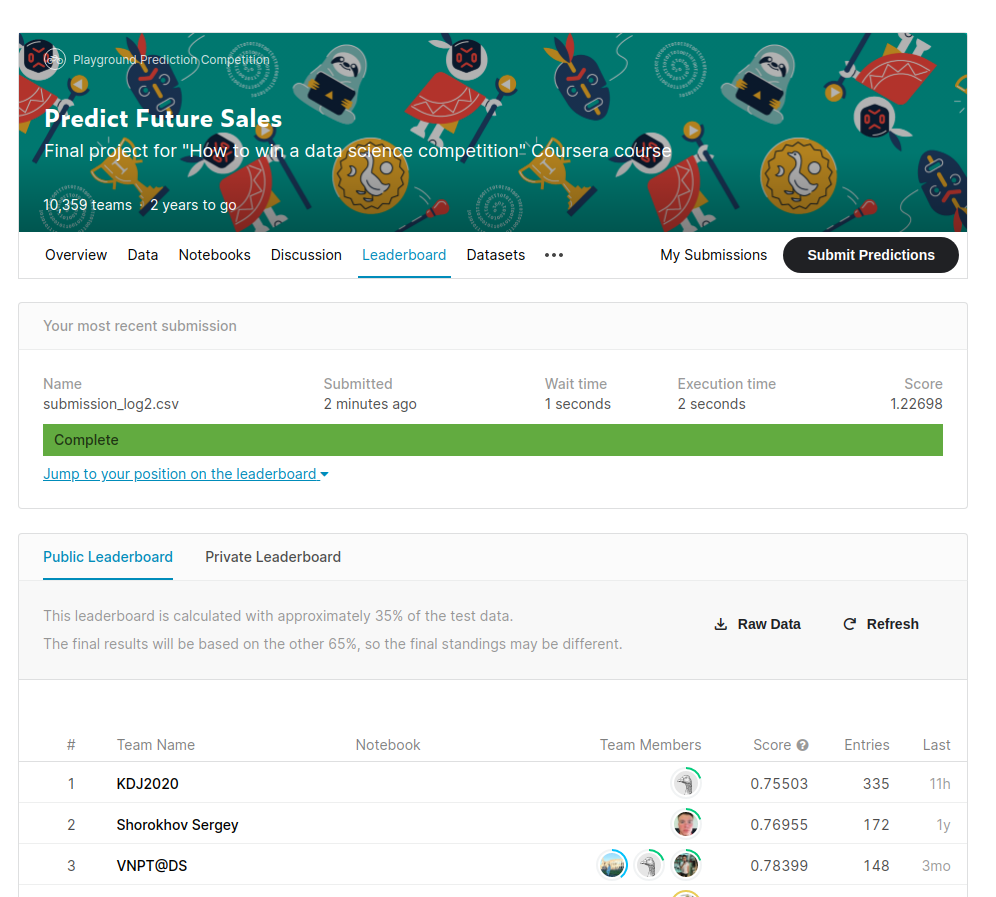

In [63]:
# Team name : 10jo
image_path = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/kaggle_score.png"
Image(image_path)

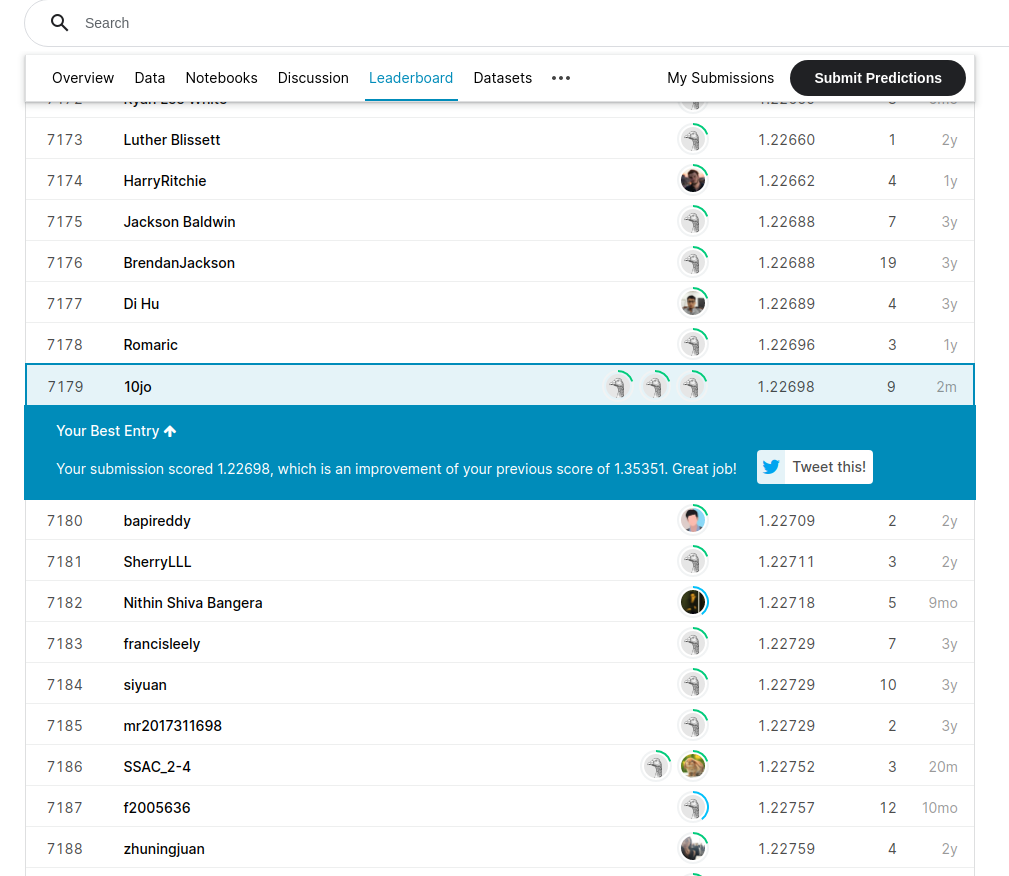

In [64]:
image_path2 = os.getenv("HOME") + "/aiffel/competitive-data-science-predict-future-sales/leaderboard.png"
Image(image_path2)